In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from seaborn import heatmap

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
DATA_PATH = '/content/gdrive/MyDrive/Colab Notebooks/data2.json' # path of the file which has the processed data stored in JSON format

def load_data(data_path):
    '''
    function to load data from the JSON file
    param: data_path -> string -> the path of the JSON file which will be used to load data
    return: X -> ndarray -> the extracted input features from the loaded file
            Y -> ndarray -> the expected output for the corresponding inputs in X
    '''
    
    with open(data_path, "r") as fp:
        data = json.load(fp)
    
    # converting list to ndarrays
    X = np.array(data['mfcc'])
    Y = np.array(data['labels'])
    mappings = data['mappings']
    print('Data Loaded Successfully!')
    
    return X, Y, mappings

X, Y, mappings = load_data(DATA_PATH) # loading data to X and Y

def plot_history(history):
    # function to plot the history of the training of the model
    
    fig, axs = plt.subplots(2)
    
    # plotting accuracy history of training and validation datasets
    axs[0].plot(history.history["accuracy"], label = 'train-accuracy')
    axs[0].plot(history.history["val_accuracy"], label = 'validation-accuracy')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epochs')
    axs[0].legend(loc = 'lower right')
    axs[0].set_title('Accuracy Evaluation')
    
    # plotting error history of training and validation datasets
    axs[1].plot(history.history["loss"], label = 'training-loss')
    axs[1].plot(history.history["val_loss"], label = 'validation-loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].legend('upper right')
    axs[1].set_title('Loss Evaluation')
    
    plt.show()
    
def prepare_dataset(validation_size, test_size):
    # function to split the dataset into traning, validation and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

Data Loaded Successfully!


(5991, 130, 23, 1) (5991,)
(130, 23, 1)
(None, 15, 2, 60)
(None, 15, 120)
(None, 15, 120)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 128, 21, 30)       300       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 64, 11, 30)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 64, 11, 30)        0         
                                                                 
 batch_normalization_18 (Bat  (None, 64, 11, 30)       120       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 62, 9, 60)         16260     
                              

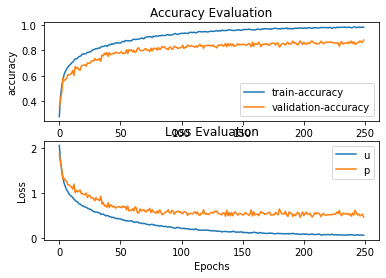

Test Accuracy: 0.8753753753753754


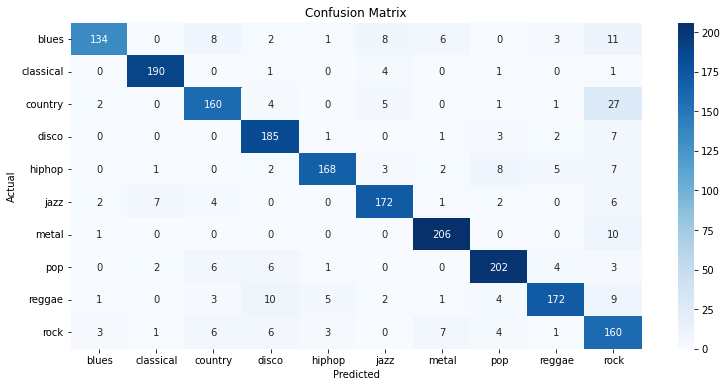

(9986, 130, 23) (9986,)


In [ ]:
def build_model(input_shape):
    # building a RNN-LSTM model
    model = keras.Sequential()
    
    # adding Convolutional layers
    cnn = keras.layers.Conv2D(30, (3, 3), activation = 'relu', input_shape = input_shape)
    model.add(cnn)
    
    cnn = keras.layers.MaxPooling2D((2, 2), padding = 'same')
    model.add(cnn)

    cnn = keras.layers.Dropout(0.1)
    model.add(cnn)
    model.add(keras.layers.BatchNormalization())

    cnn = keras.layers.Conv2D(60, (3, 3), activation = 'relu')
    model.add(cnn)
    
    cnn = keras.layers.MaxPooling2D((3, 3), strides = (2, 2), padding = 'same')
    model.add(cnn)
    
    cnn = keras.layers.Dropout(0.1)
    model.add(cnn)
    model.add(keras.layers.BatchNormalization())

    cnn = keras.layers.Conv2D(60, (3, 3), activation = 'relu')
    model.add(cnn)
    
    cnn = keras.layers.MaxPooling2D((4, 4), strides = (2, 2), padding = 'same')
    model.add(cnn)
    
    cnn = keras.layers.Dropout(0.1)
    model.add(cnn)
    model.add(keras.layers.BatchNormalization())

    output_shape = cnn.output_shape
    print(output_shape)
    
    # reshaping the dimensions to shift from cnn to rnn
    reshape = keras.layers.Reshape(target_shape = (output_shape[1], int(output_shape[2] * output_shape[3])))
    model.add(reshape)
    print(reshape.output_shape)
    
    output_shape = reshape.output_shape
    print(output_shape)
    
    rnn = keras.layers.LSTM(30, return_sequences = True)
    model.add(rnn)
    
    rnn = keras.layers.LSTM(30)
    model.add(rnn)
    
    last = keras.layers.Dense(10, activation = 'softmax')
    model.add(last)
      
    return model

def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    
    plt.figure(figsize=(12.8,6))
    heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

    plt.show()

if(__name__ == '__main__'):
    X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_dataset(0.25, 0.2)
    print(X_train.shape, Y_train.shape)
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    print(input_shape)
    model = build_model(input_shape)
    
    optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
    
    model.compile(optimizer = optimizer,
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
    
    model.summary()
    
    history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size = 32, epochs = 250)
    
    plot_history(history)
    

    predictions = model.predict(X_test).tolist()

    
    predicted_classes = [np.array(xi).argmax() for xi in predictions]

    

    test_accuracy = accuracy_score(predicted_classes, Y_test)
    
    print(f'Test Accuracy: {test_accuracy}')

    
    predicted_classes = [mappings[np.array(xi).argmax()] for xi in predictions]
    Y_test_classes = [mappings[di] for di in Y_test]
    plot_confusion_matrix(Y_test_classes, predicted_classes, mappings)
    
    # print(X.shape, Y.shape)

[[3.07629925373476e-05, 5.454188567455276e-07, 2.2237136363401078e-05, 0.9996902942657471, 1.3660618606081698e-05, 1.6419051007687813e-06, 6.293212663877057e-06, 1.2444115782273002e-05, 1.1220728083571885e-05, 0.00021075484983157367], [0.00013901620695833117, 0.0006528442609123886, 0.00035894999746233225, 7.941337571537588e-06, 0.00018864579033106565, 0.9984803795814514, 9.458376553084236e-06, 5.220199000177672e-06, 1.8910484868683852e-05, 0.00013869018584955484], [1.0399983239040012e-06, 5.719754335586913e-05, 1.8789665773510933e-05, 4.128354339627549e-05, 5.39698448847048e-05, 1.2448379038687563e-07, 2.0470104118430754e-06, 0.9996104836463928, 9.6130252131843e-06, 0.0002054170035989955], [0.028675399720668793, 2.953829061880242e-05, 0.0016912592109292746, 0.12077843397855759, 5.393178798840381e-05, 0.00028282662970013916, 1.5149673345149495e-05, 0.00013098046474624425, 0.8472355604171753, 0.0011069013271480799], [1.6673458276272868e-06, 0.00025255384389311075, 1.0920781278400682e-05,

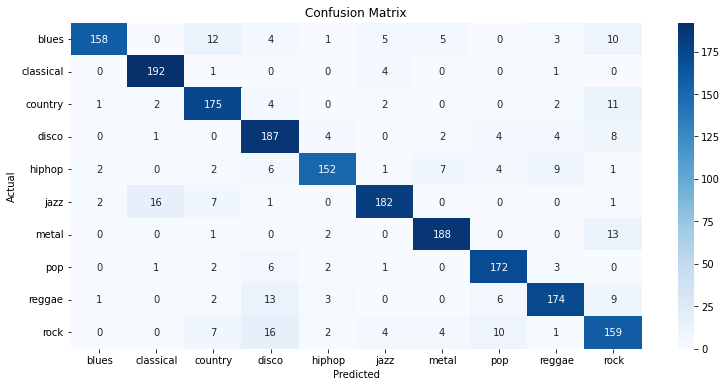

In [ ]:
predicted_classes = [mappings[np.array(xi).argmax()] for xi in predictions]
Y_test_classes = [mappings[di] for di in Y_test]
plot_confusion_matrix(Y_test_classes, predicted_classes, mappings)